In [15]:
import numpy as np
import glob
from PTMCMCSampler import PTMCMCSampler

import scipy
import scipy.stats
from scipy.integrate import odeint
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from numba import jit
from matplotlib import cm
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import timeit

In [16]:
# Soil Carbon 

def Analysis(x):
    mean=np.mean(x,0)
    median=np.median(x,0)
    var=np.var(x,0)

    ess=np.zeros( x.shape[1])
    for i in range( x.shape[1] ):
      ess[i]=tfp.mcmc.effective_sample_size(  x[:,i] , filter_beyond_positive_pairs=True)
    
    mess=np.min(ess)

    summary= {
        "Mean": mean,
        "Median":median,
        "Variance": var,
        "mVar": var/ess,
        "ess": ess,
        "mess":mess, #min ess

        }
    return summary

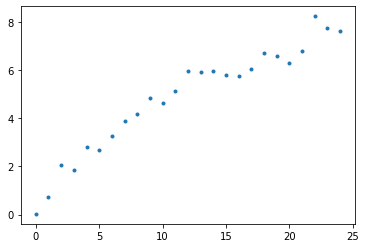

In [17]:

data=pd.read_csv('CO2-2.csv')
data=data.values

totalC_t0=7.7 #not included in data
t0=0
Nt=25
ts=data[0:25,1]
eco2mean=data[0:25,2]
eco2sd=data[0:25,3]


ts=ts.astype(float)
eco2mean=eco2mean.astype(float)
eco2sd=eco2sd.astype(float)


plt.plot(eco2mean,'.')


In [30]:
#Functions


def scODE( X,t, k1, k2, alpha21, alpha12):
    dC1dt= -k1*X[0]+ alpha12*k2*X[1]
    dC2dt= -k2*X[1]+ alpha21*k1*X[0]
    return np.array([ dC1dt, dC2dt  ])


class PT_target(object):
    
    def logL(self,theta):
        k1,k2,alpha21, alpha12, sigma, gamma=theta 
        if( all(theta>0) and gamma<1 ):
            X0=np.array( [ gamma*totalC_t0, (1-gamma)*totalC_t0 ] )
            Xt = odeint( scODE, X0, ts, args=( k1, k2, alpha21, alpha12),)
            C1t=Xt[:,0]
            C2t=Xt[:,1]
            eCO2hat= totalC_t0-( C1t+C2t)
            eCO2hat[eCO2hat<0]=0
            ll=np.sum(scipy.stats.norm.logpdf( x=eco2mean , loc=eCO2hat,scale=sigma))
            return ll
        else:
            return -np.inf
   
    
    
    def log_prior(self, theta):
        k1,k2,alpha21, alpha12, sigma, gamma=theta 
        if( all(theta>0) and gamma<1 ):
            a=np.sum(scipy.stats.halfnorm.logpdf([k1,k2,alpha21, alpha12]))
            b=scipy.stats.halfcauchy.logpdf(sigma)+scipy.stats.beta.logpdf(x=gamma, a=10, b=1)
            return a+b
        else:
            return -np.inf

def p0(size):
    p0=scipy.stats.uniform.rvs(0, 1, size)    
    
    return p0


        

In [36]:
f=PT_target()
cov=np.diag([ 1/2,1/2,1/2,1/2,1/2,1/2])
dim=6
T=1000000
bi=int(0.15*T)


sampler = PTMCMCSampler.PTSampler(dim, f.logL , f.log_prior, np.copy(cov), outDir='PTcaseSOIL/chains', resume=False)


initpoint=p0(6)
sampler.sample(initpoint, T, burn= bi  , thin=1, covUpdate=1000,
               SCAMweight=30, AMweight=20, DEweight=50, HMCweight=0, HMCsteps=0)
   
    
data = np.loadtxt('PTcaseSOIL/chains/chain_1.txt') #if T is changed be sure to create new directory for chain
PTchain = data[:,:-4]
    
Adata=Analysis(data)    
   

Finished 15.00 percent in 251.414226 s Acceptance rate = 0.122353Adding DE jump with weight 50
Finished 55.80 percent in 870.744197 s Acceptance rate = 0.104177

<ipython-input-30-29e5ff66ec79>:5: RuntimeWarning: overflow encountered in double_scalars
  dC1dt= -k1*X[0]+ alpha12*k2*X[1]
<ipython-input-30-29e5ff66ec79>:5: RuntimeWarning: invalid value encountered in double_scalars
  dC1dt= -k1*X[0]+ alpha12*k2*X[1]
<ipython-input-30-29e5ff66ec79>:20: RuntimeWarning: invalid value encountered in less
  eCO2hat[eCO2hat<0]=0


Finished 99.90 percent in 1606.268845 s Acceptance rate = 0.100149
Run Complete


In [37]:
Adata

{'Mean': array([  0.25195636,   0.82631323,   0.62408956,   0.71965333,
          0.35579023,   0.9107796 , -10.25958422,  -8.98379519,
          0.10881688,   1.        ]),
 'Median': array([ 0.14449328,  0.68425361,  0.63432435,  0.68692327,  0.34883075,
         0.9341419 , -9.926195  , -8.65496   ,  0.104708  ,  1.        ]),
 'Variance': array([6.29024222e-02, 3.75335755e-01, 1.21187167e-01, 2.27028355e-01,
        3.13997504e-03, 6.69728574e-03, 5.68919859e+00, 3.46728362e+00,
        1.38203254e-04, 0.00000000e+00]),
 'mVar': array([2.52718537e-04, 4.77937477e-04, 2.13129296e-04, 4.50767728e-04,
        4.71218258e-07, 4.45388199e-06, 3.78277479e-03, 3.07150518e-04,
        2.63345436e-05,            nan]),
 'ess': array([2.48903080e+02, 7.85323966e+02, 5.68608675e+02, 5.03648202e+02,
        6.66352583e+03, 1.50369627e+03, 1.50397497e+03, 1.12885488e+04,
        5.24798363e+00,            nan]),
 'mess': nan}

In [ ]:
results=pd.DataFrame( PTchain)
sns.set()
sns.pairplot(results, markers='.', plot_kws=dict(s=1, edgecolor="b"),diag_kws=dict(bins=15) )
plt.savefig('PTpairplot', dpi=500)